# Explorando dados para estartégia de redução do Churn

Objetivos da análise:

- Visualizar quais serviços tem maior taxa de avaliações negativas e suas métricas de grandeza
- Entender qual serviço tem maior janela de oportunidade e quais apresentam maior ameaça em relação ao churn
- Traçar grupos para cada tipo de serviço prestado
- Observar grupos de clientes e traçar perfis para criar estratégias e evitar churn

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Definindo as pastas do diretório

root = os.getcwd()
dataFolder = os.path.join(root, 'data')
docFolder = os.path.join(root, 'doc')

In [3]:
# Definindo cores do Seaborn

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('Set1')

# 01) Importantdo os dados tratados

In [4]:
df = pd.read_csv(os.path.join(dataFolder, 'dados_tratados.csv'), sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Nome                            102 non-null    object 
 1   Idade                           102 non-null    int64  
 2   Gênero                          102 non-null    object 
 3   Estado Civil                    102 non-null    object 
 4   Número de Dependentes           102 non-null    int64  
 5   Data de Início do Contrato      102 non-null    object 
 6   Data de Término do Contrato     4 non-null      object 
 7   Valor Mensal do Contrato        102 non-null    float64
 8   Tipo de Serviço                 102 non-null    object 
 9   Duração Média das Chamadas      102 non-null    float64
 10  Comentários                     102 non-null    object 
 11  Última data de contrato ativo   102 non-null    object 
 12  Houve término de contrato       102 

In [5]:
# Transformando o tempo de contrato em variável int

df['Tempo ativo de contrato - dias'] = df['Tempo ativo de contrato - dias'].str.removesuffix('days').astype('int')

# 02) Observando historicamente a grandeza e a qualidade dos serviços

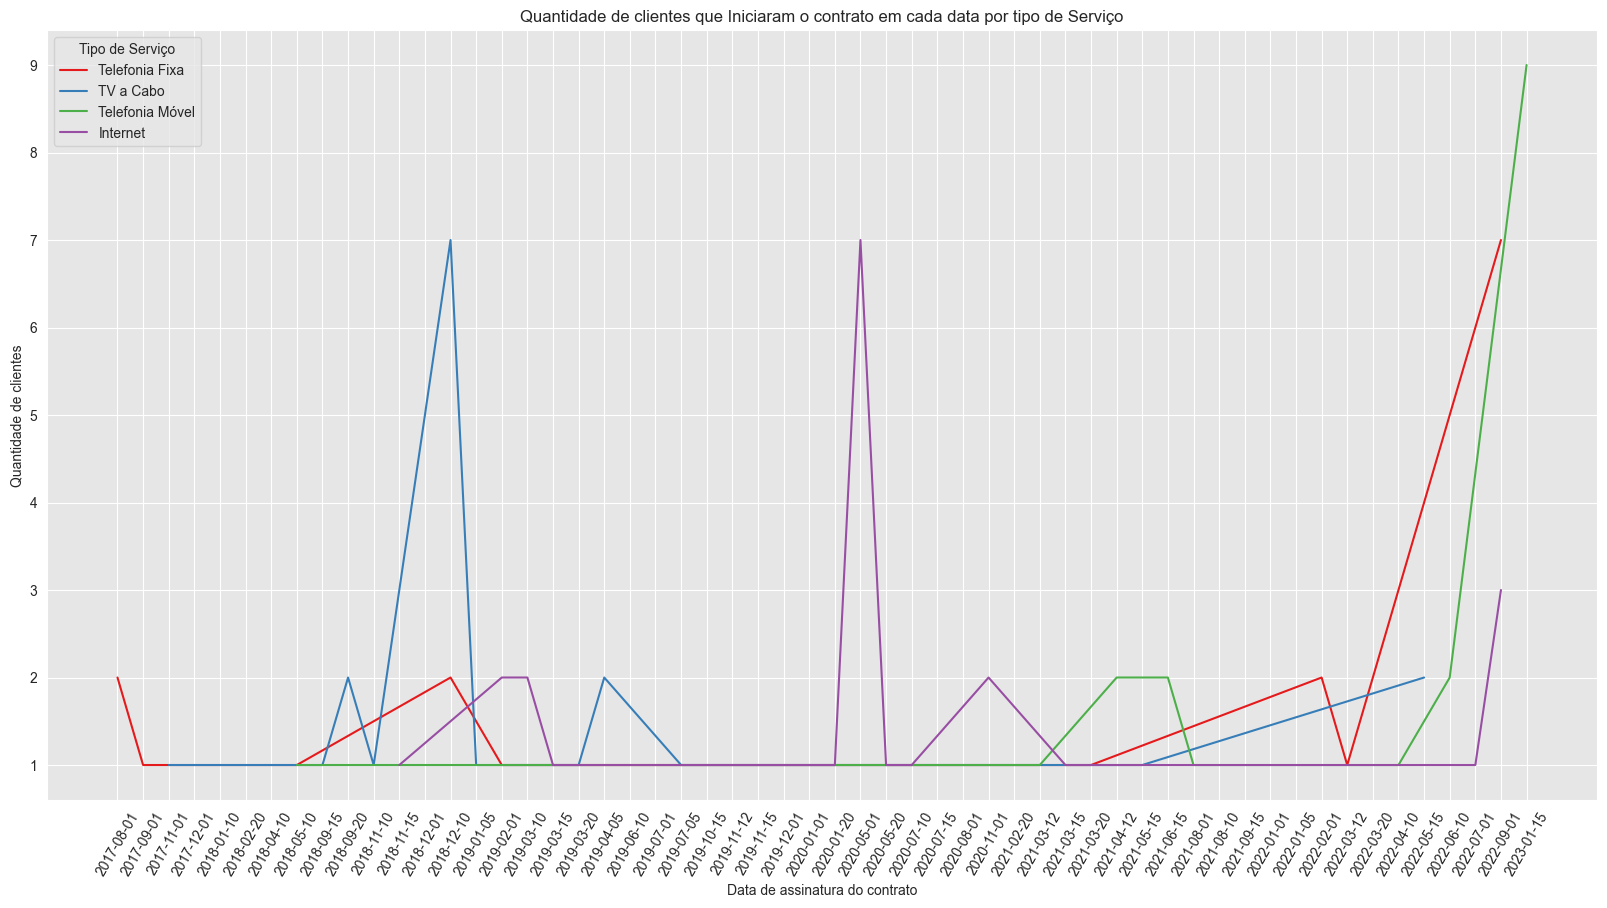

In [67]:
# Vendo a quantidade de clientes que assinaram o serviço por data

df_serie_historica_qtd = pd.DataFrame(df.groupby(['Tipo de Serviço', 'Data de Início do Contrato']).size()).reset_index().sort_values('Data de Início do Contrato')

plt.figure(figsize=(20,10))
sns.lineplot(data=df_serie_historica_qtd, x='Data de Início do Contrato', y=0, hue='Tipo de Serviço')
plt.title("Quantidade de clientes que Iniciaram o contrato em cada data por tipo de Serviço")
plt.ylabel("Quantidade de clientes")
plt.xlabel("Data de assinatura do contrato")
plt.xticks(rotation = 60)

path_fig = os.path.join(docFolder, 'serie_historica_contratos.png')
plt.savefig(path_fig)

plt.show()

In [8]:
# Quantidade de clientes acumulado históricamente para cada tipo de serviço

print("Contribuição histórica para a quantidade de clientes total por tipo de serviço:")
df.groupby('Tipo de Serviço').size()

Contribuição histórica para a quantidade de clientes total por tipo de serviço:


Tipo de Serviço
Internet           31
TV a Cabo          25
Telefonia Fixa     23
Telefonia Móvel    23
dtype: int64

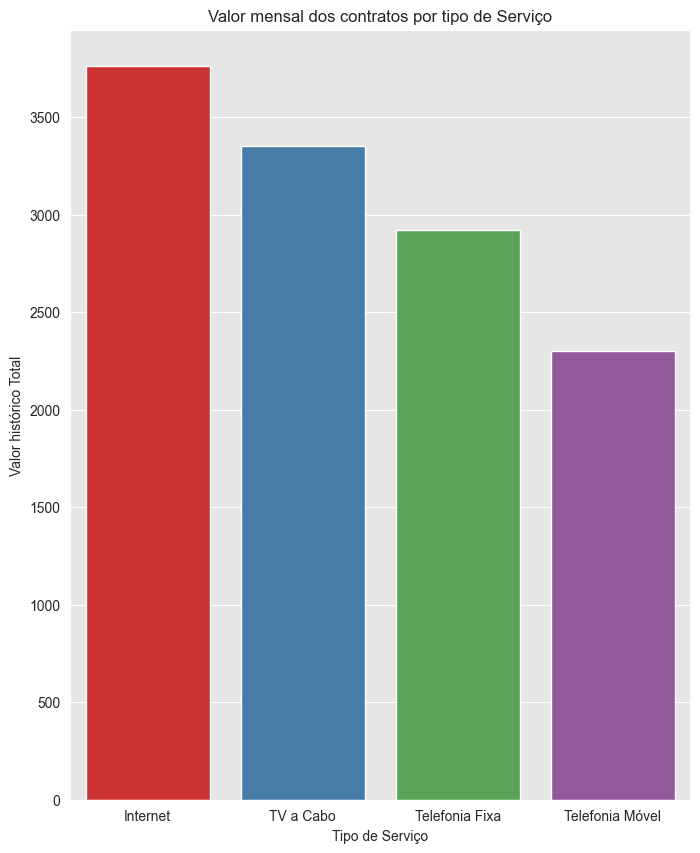

In [68]:
# Vendo o valor mensal dos contratos dos clientes por tipo de serviço

df_valor_agregado = pd.DataFrame(df.groupby('Tipo de Serviço')['Valor Mensal do Contrato'].sum()).reset_index()

plt.figure(figsize=(8,10))
sns.barplot(data=df_valor_agregado, x='Tipo de Serviço', y='Valor Mensal do Contrato')
plt.title("Valor mensal dos contratos por tipo de Serviço")
plt.ylabel("Valor histórico Total")
plt.xlabel("Tipo de Serviço")

path_fig = os.path.join(docFolder, 'valor_contratos_servico.png')
plt.savefig(path_fig)

plt.show()

In [8]:
# Estatísticas descritivas dos valores de contratos mensal para cada serviço

print("Estatísticas descritivas:\n")
df[['Tipo de Serviço', 'Valor Mensal do Contrato']].groupby('Tipo de Serviço').describe()

Estatísticas descritivas:



Valor Mensal do Contrato                                \
                                   count        mean        std    min   
Tipo de Serviço                                                          
Internet                            31.0  121.280323  22.618862  69.99   
TV a Cabo                           25.0  133.990000  24.152295  99.99   
Telefonia Fixa                      23.0  126.946522  32.673979  99.99   
Telefonia Móvel                     23.0   99.990000  17.580981  79.99   

                                                 
                    25%     50%     75%     max  
Tipo de Serviço                                  
Internet          99.99  119.99  144.99  149.99  
TV a Cabo        109.99  129.99  149.99  179.99  
Telefonia Fixa    99.99  109.99  144.99  189.99  
Telefonia Móvel   89.99   89.99  109.99  149.99

In [9]:
# Valor total de contribuição para cada serviço

print("Contribuição histórica para o faturamento total por tipo de serviço:\n")
df_valor_agregado.sort_values('Valor Mensal do Contrato', ascending=False)
df_valor_agregado['Percentual total'] =  (df_valor_agregado['Valor Mensal do Contrato'] / (df_valor_agregado['Valor Mensal do Contrato'].sum())) * 100

df_valor_agregado

Contribuição histórica para o faturamento total por tipo de serviço:



,Tipo de Serviço,Valor Mensal do Contrato,Percentual total
0,Internet,3759.69,30.494737
1,TV a Cabo,3349.75,27.169725
2,Telefonia Fixa,2919.77,23.682170
3,Telefonia Móvel,2299.77,18.653368


**Anotações:**

- A maior tendência de novos contratos nos últimos anos são de serviços de Telefonia, idependente de serem telefonia Fixa ou Móvel.
- O maior número de clientes acumulado, históricamente, são cliente que utilizam o serviço de Internet, acumulando 30% dos clientes totais da base.
- O serviço que mais trouxe, históricamente, contratos com maior valor mensal são os serviços de Internet e Tv a Cabo.
- A distribuição dos valores dos contratos mensais segue um comportamento semelhante, onde o serviço de Internet tem a maior amplitude entre os valores mensais de pacote, o serviço de Telefonia fixa a maior diversidade de diferentes valores, o serviço de TV a Cabo a maior média e o de Telefonia Móvel a menor média.
- 50% de todo o valor mensal em contratos vem dos serviços de Internet e TV a Cabo.


# 03) Observando quais serviços tem maior janela de oportunidade de melhoria em relação aos comentários

In [76]:
# Visualizando quais serviços tiveram quebra de contrato segundo a base de dados
print("Serviços com quebra de contrato registada:\n")
df.groupby('Tipo de Serviço')['Houve término de contrato'].sum()

Serviços com quebra de contrato registada:



Tipo de Serviço
Internet           1
TV a Cabo          3
Telefonia Fixa     0
Telefonia Móvel    0
Name: Houve término de contrato, dtype: int64

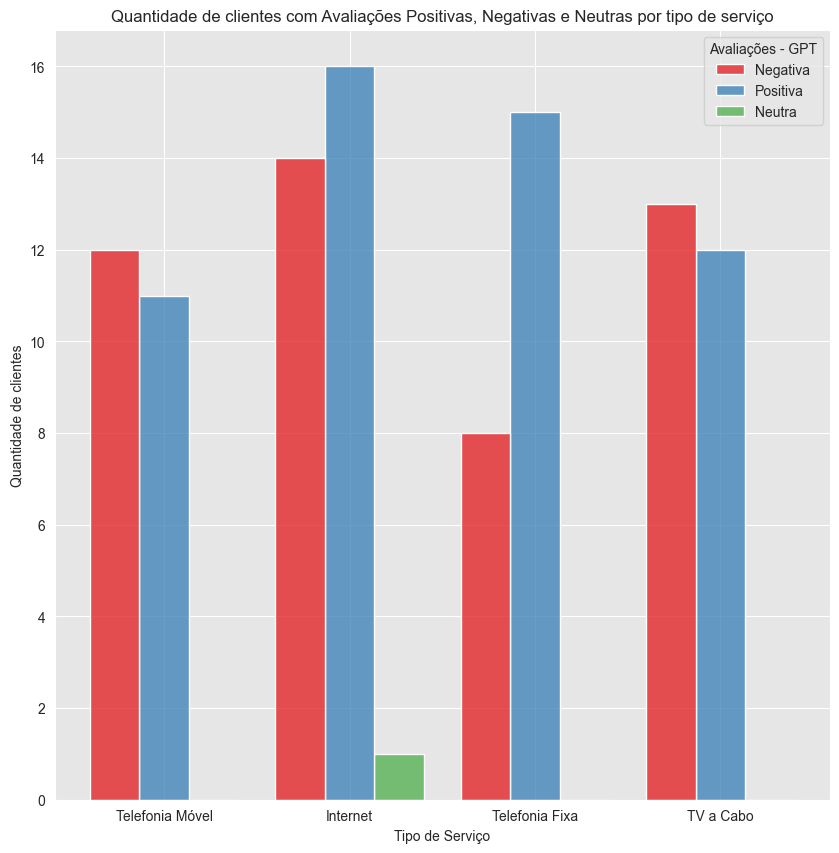

In [69]:
# Plotando o Histograma da quantidade de clientes em cada tipo de serviço por taxa de avaliação

plt.figure(figsize=(10,10))
plt.title("Quantidade de clientes com Avaliações Positivas, Negativas e Neutras por tipo de serviço")
sns.histplot(data=df, x ='Tipo de Serviço', hue='Avaliações - GPT', multiple='dodge', shrink=.8)
plt.ylabel("Quantidade de clientes")
path_fig = os.path.join(docFolder, 'distribuicao_clientes_avaliacoes.png')
plt.savefig(path_fig)
plt.show()

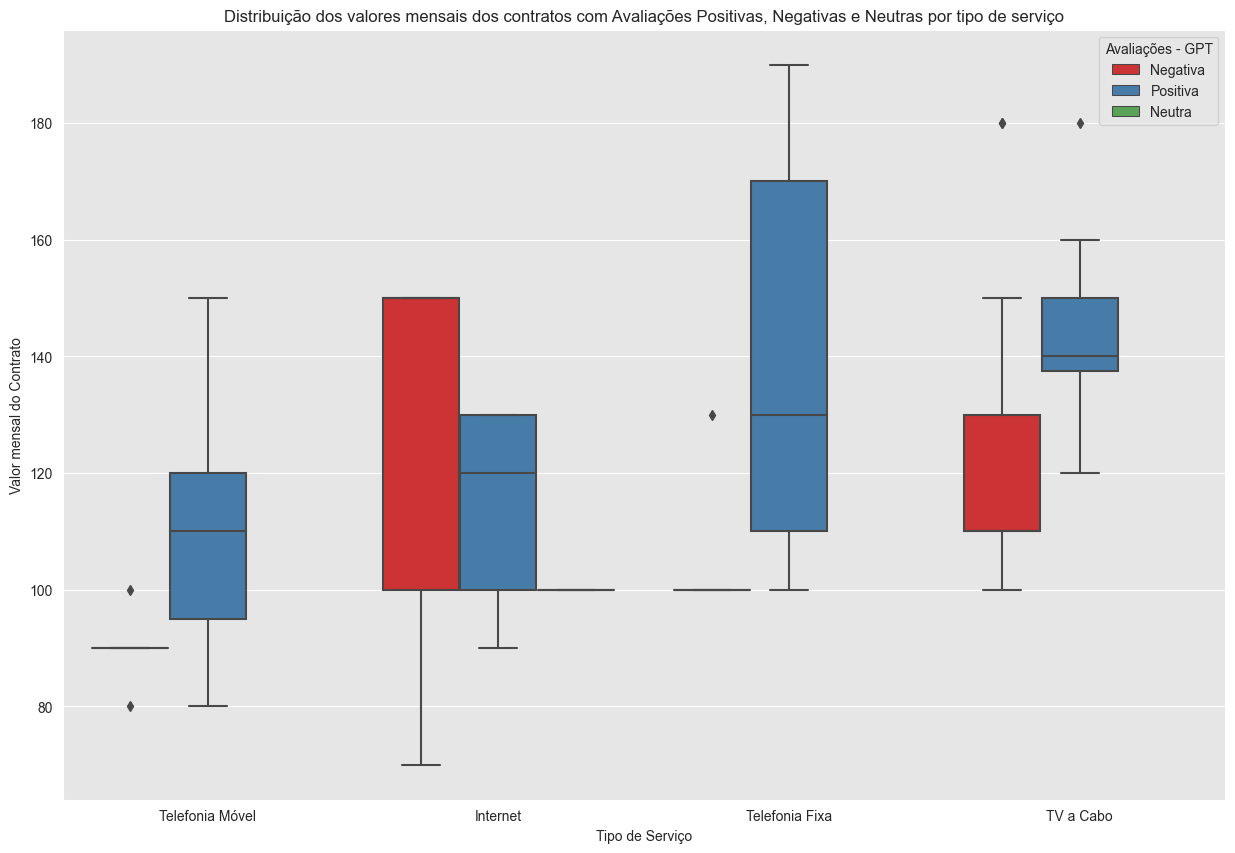

In [70]:
# Plotando a soma do valor mensal dos contratos dos clientes em cada tipo de serviço por taxa de avaliação

plt.figure(figsize=(15,10))
plt.title("Distribuição dos valores mensais dos contratos com Avaliações Positivas, Negativas e Neutras por tipo de serviço")
sns.boxplot(data=df, y ='Valor Mensal do Contrato', x='Tipo de Serviço', hue='Avaliações - GPT')
plt.ylabel("Valor mensal do Contrato")
path_fig = os.path.join(docFolder, 'distribuicao_valores_avaliacoes.png')
plt.savefig(path_fig)
plt.show()

c:\Users\gusta\Documents\GitHub\desafio-churn-telecom\env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


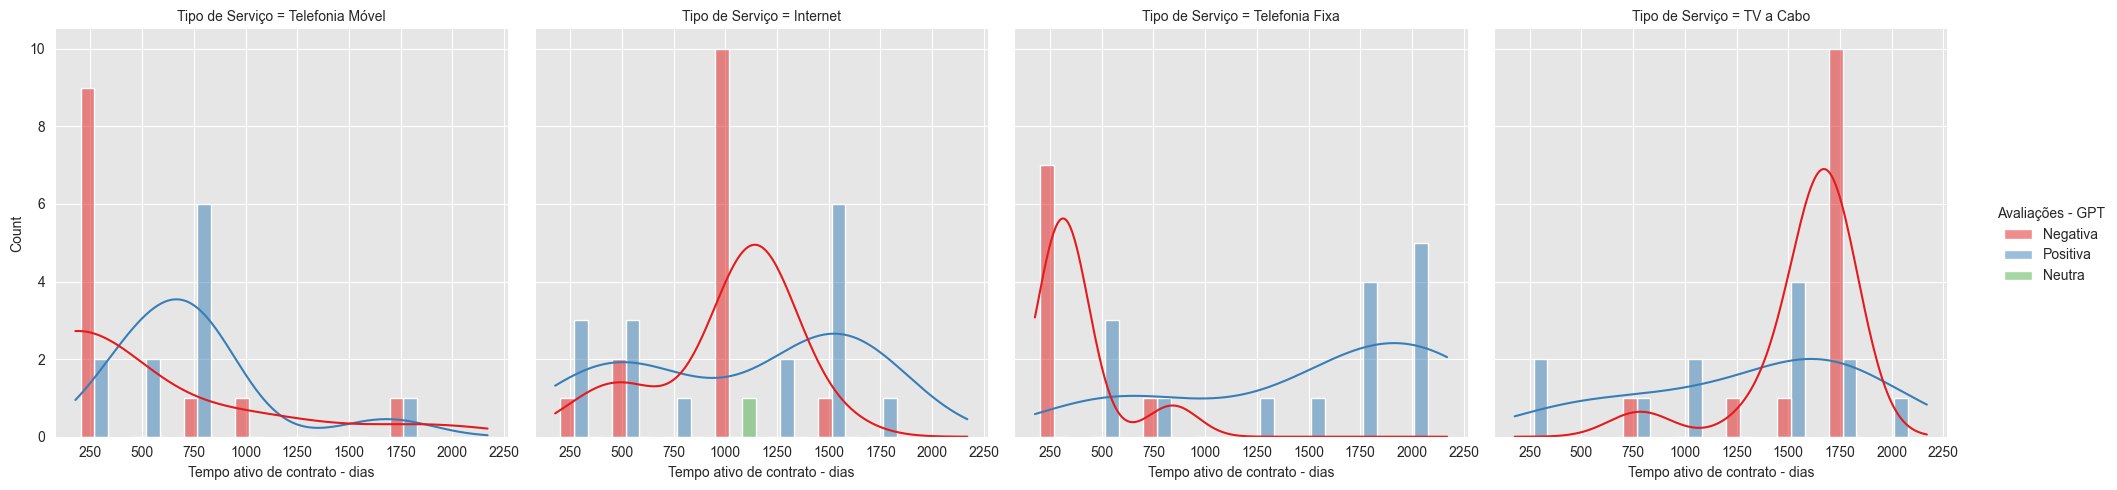

In [58]:
# Observando a distribuição do tempo de contrato com as avaliações
sns.displot(df, x ='Tempo ativo de contrato - dias', hue='Avaliações - GPT', col='Tipo de Serviço', kde=True, multiple='dodge', shrink=.8)
plt.ylabel("Quantidade de clientes")
path_fig = os.path.join(docFolder, 'distribuicao_tempo_contrato_avaliacoes.png')
plt.savefig(path_fig)
plt.show()

**Anotações:**

- Históricamente (pela base de dados fornecida), temos 4 quebras de contrato registradas, sendo 1 do serviço de Internet e 3 do serviço de TV a Cabo.
- Os serviços de Telefonia Móvel e TV a Cabo apresentaram maior quantidade de clientes com avaliações negativas do que positivas.
- Os serviços de Internet e Telefonia Fixa apresentaram maior quantidade de clientes com avaliações positivas, sendo o de Telefonia fixa com a maior proporção.
- Apenas uma avaliação foi considerada Neutra, que se encontra em um cliente que utiliza o pacote de Internet.
- Os serviços de Telefonia tem concentratado os maiores valores de Contratos Mensais nos clientes que avaliam o serviço positivamente.
- O serviço de TV a Cabo tem um mix na distribuição de valores, onde na média o valor pago pelas pessoas que avaliam negativamente é menor que as positivamente.
- O serviço de internet é o com pior balanço entre valor médio pago x avaliações. A distribuição de quem avalia o serviço de Internet de forma ruim é mais abrangente do que quem avalia positivamente.
- Para cada tipo de serviço, temos uma jornada diferente de tempo em que o cliente se ecnontra mais ou menos satisfeito, portanto é necessário ter uma jornada que faça sentido para o período temporal.

# 04) Observando quais variáveis provavelmente estão mais ligadas a avaliações negativas dos produtos

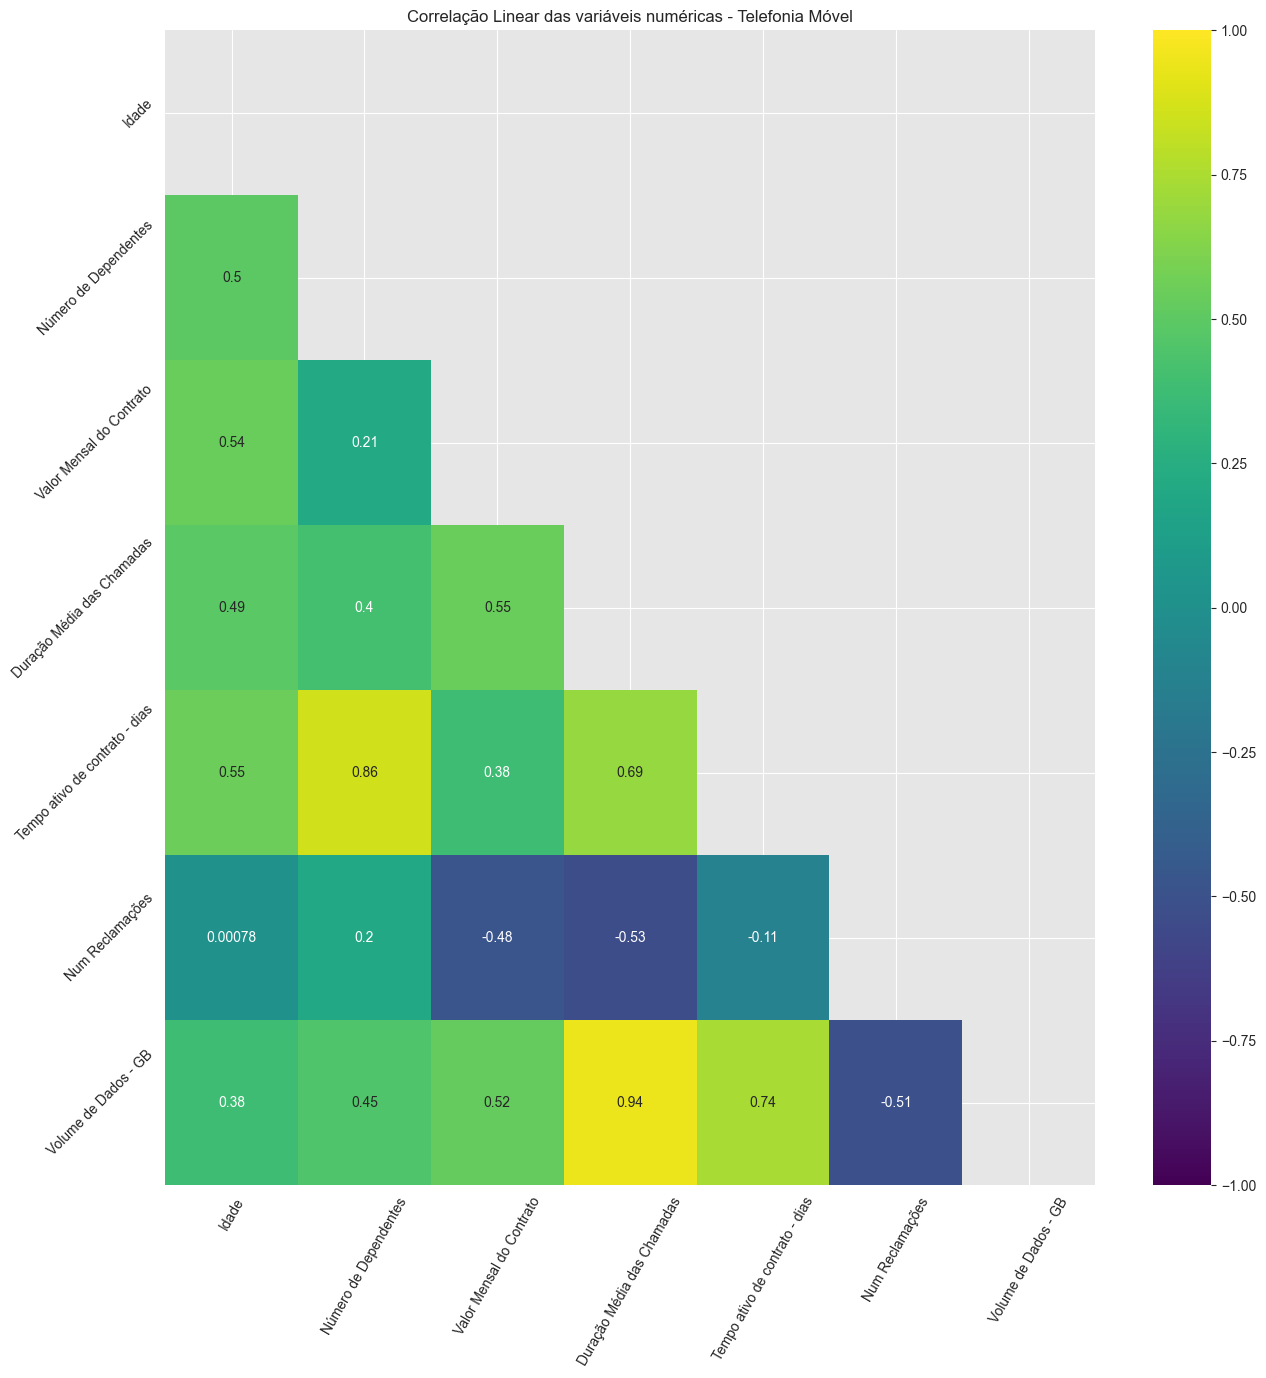

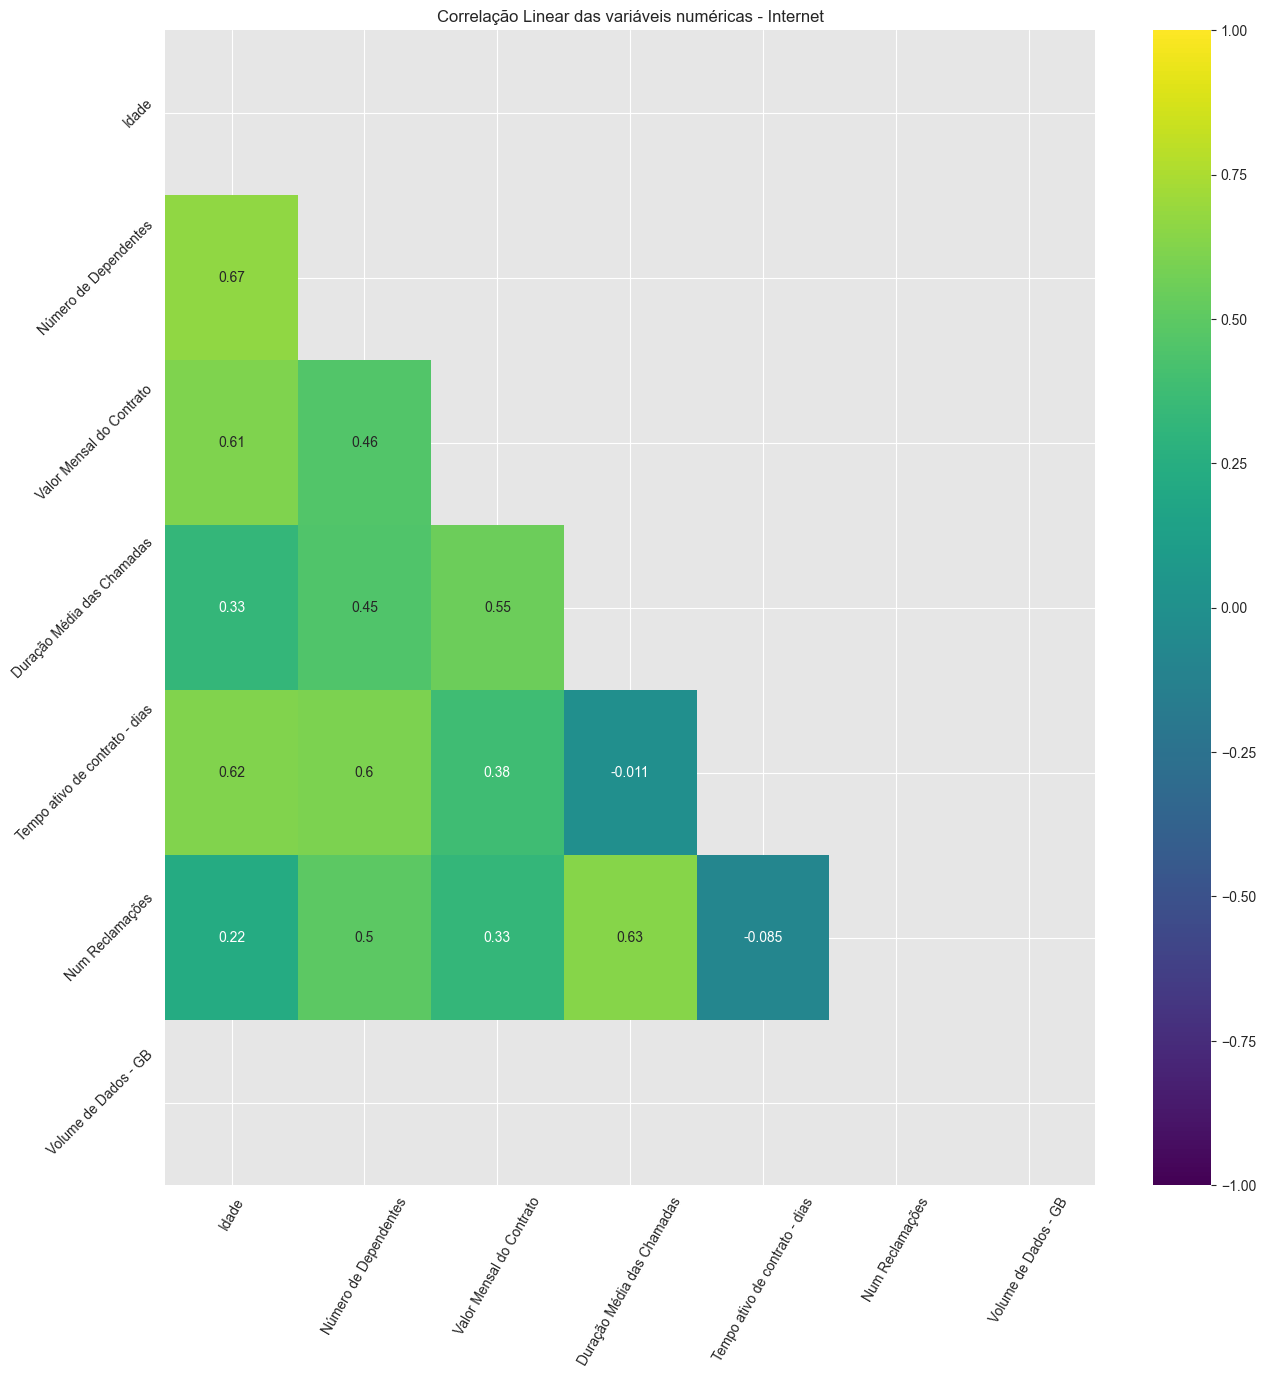

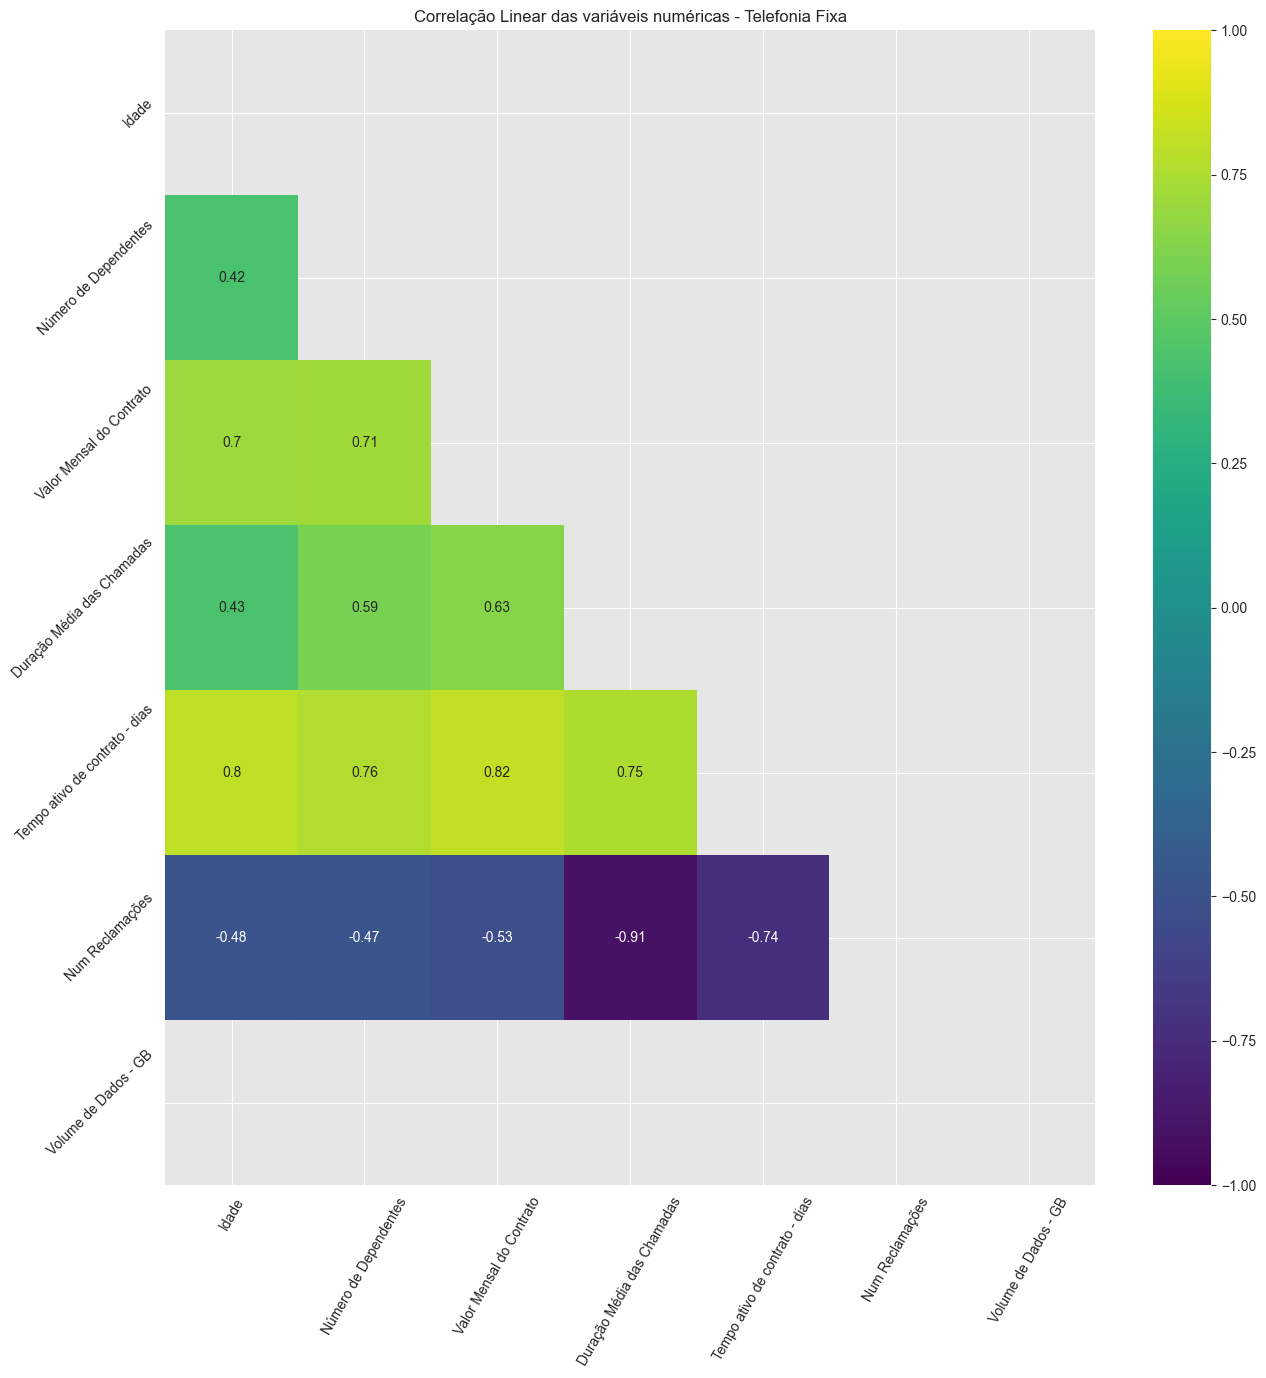

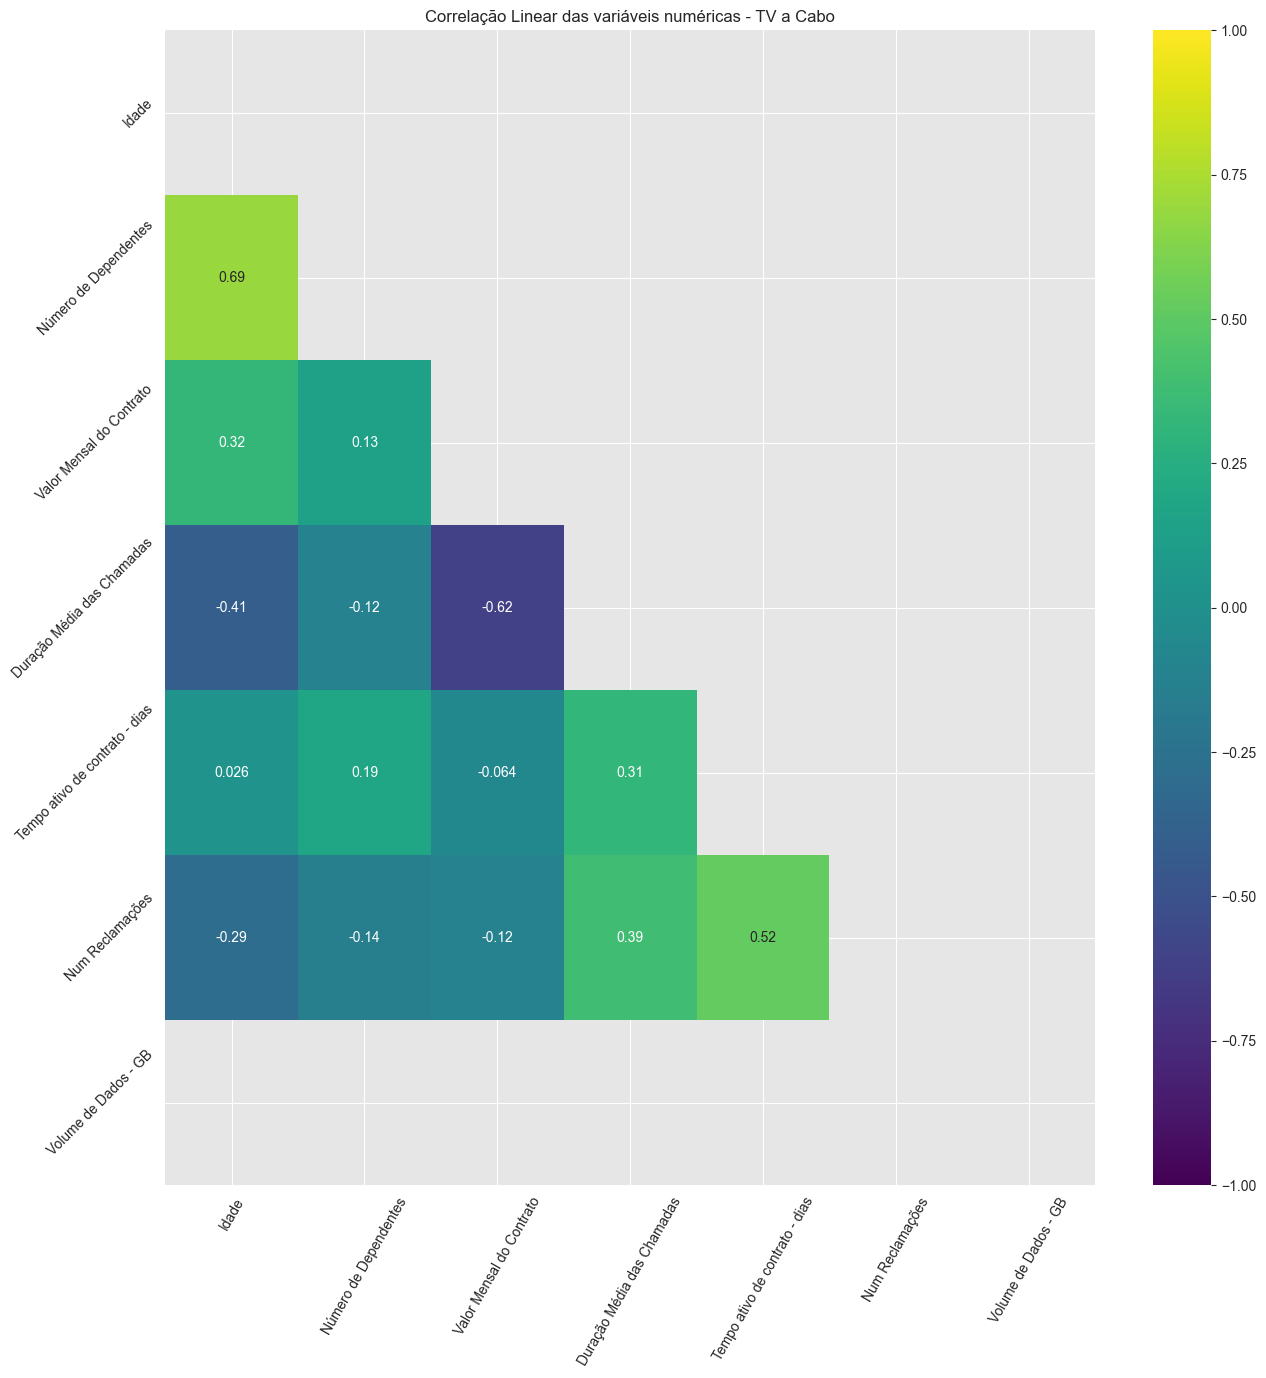

In [23]:
# Visualizando a correlação linear (Pearson) das variáveis numéricas para cada um dos tipos de serviço

lista_servicos = df['Tipo de Serviço'].unique()

for servico in lista_servicos:
    df_filtrado = df[df['Tipo de Serviço'] == servico]
    matriz_correlacao = df_filtrado.select_dtypes(['int', 'float']).corr()
    mask = np.triu(matriz_correlacao)

    plt.figure(figsize=(15,15))
    sns.heatmap(matriz_correlacao, vmin = -1, vmax = +1, annot = True, cmap = 'viridis', mask = mask)
    plt.title(f"Correlação Linear das variáveis numéricas - {servico}")
    plt.xticks(rotation=60)
    plt.yticks(rotation=45)
    plt.savefig(os.path.join(docFolder, f'correlacao_pearson_{servico}.png'))
    plt.show()

**Anotações:**

*Para o serviço de Telefonia Móvel:*
- O número de reclamações tende a cair com o Aumento do Volume de Dados e a Duração das média chamadas.
- Pessoas com maior tempo de contrato constumam ter mais dependentes e ter pacotes com maior volume de dados.
- A idade não parece estar ligada as reclamações.

*Para o serviço de Internet:*
- O contrato aparenta ser mais duradouro em pessoas mais velhas (Maior número de dependentes, Valor mensal e Tempo ativo de contrato).

*Para o serviço de Telefonia Fixa:*
- O tempo de contrato parece estar relacionado diretamente com a Idade e inversamente com o número de reclamações.
- A quantidade de reclamações feitas é maior em quem é mais jovem do que nos clientes mais velhos.
- O número de dependentes está intimimamente ligado a quantidade de reclamações. Quanto mais dependentes, menor as reclamações (sinal de saúde do relacionamento com o cliente).

*Para o serviço de TV a Cabo:*
- O tempo de contrato não parece estar relacionado a Idade, mas está relacionado diretamente com o número de reclamações. Maior quantidade de reclamações são feitas a medida que o tempo com o contrato se aumenta.
- Pessoas mais velhas tendem a terem pacotes maiores, com maior valor mensal e mais dependentes.

# 05) Traçando grupos para cada tipo de serviço prestado

In [25]:
# Separando diferentes dataframes de acordo com o serviço para facilitar análises futuras
# Assim, como dataframe original e os particionados é possível prosseguir com a clusterização dos grupos

df_cluster = df.drop(columns=['Nome', 'Data de Início do Contrato', 'Data de Término do Contrato', 'Comentários', 'Última data de contrato ativo', 'Houve término de contrato'])

df_telefone_movel = df_cluster[df_cluster['Tipo de Serviço'] == 'Telefonia Móvel']
df_telefone_fixo = df_cluster[df_cluster['Tipo de Serviço'] == 'Telefonia Fixa'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])
df_internet = df_cluster[df_cluster['Tipo de Serviço'] == 'Internet'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])
df_tv = df_cluster[df_cluster['Tipo de Serviço'] == 'TV a Cabo'].drop(columns=['Volume de Dados - GB', 'Duração Média das Chamadas'])

In [26]:
# Função que determina a clusterização dos dados e retorna os pontos centrais
# Faz a separação de variáveis numéricas e categoricas para utilizar o método KPrototypes
# Esse método lida com os dois tipos de variáveis de forma distinta de uma única vez (separação por distância para numéricas e prob. para textuais)

def make_cluster(dataframe, max_cluster):

    # Separa variaveis categoricas das numericas
    dados_numericos = dataframe.select_dtypes(['int', 'float'])
    dados_textual = dataframe.drop(columns=dados_numericos.columns)

    # Normaliza os dados numericos
    scaler = MinMaxScaler().fit(dados_numericos)
    df_scaler = scaler.fit_transform(dados_numericos)
    df_escala = pd.DataFrame(df_scaler, columns=dados_numericos.columns, index=dados_textual.index)

    # Une as variaveis novamente e gera a matrix de treino
    df_pipe = pd.concat([dados_textual, df_escala], axis=1)
    df_matrix = df_pipe.to_numpy()
    
    # Indexa as variaveis categoricas
    catColumns = [dados_textual.columns.get_loc(col) for col in list(dataframe.select_dtypes('object').columns)]

    # Percorre o valor total de clusteres para encontrar os melhores classificadores
    valores_cost = []
    faixa_n_clusteres  = list(range(2, max_cluster))
    seed = 1337
    for cluster in faixa_n_clusteres:

        kproto = KPrototypes(n_clusters=cluster, n_jobs=-1, random_state=seed)
        kproto.fit_predict(df_matrix, categorical=catColumns)
        custo = kproto.cost_
        valores_cost.append(custo)
        print(f"Número de cluster: {cluster}. Valor de perda: {custo}")

    # Definindo o melhor valor de cluster
    def optimal_number_of_clusters(cost_values, max_cluster):
        x1, y1 = 2, cost_values[0]
        x2, y2 = max_cluster, cost_values[len(cost_values)-1]

        distances = []
        for i in range(len(cost_values)):
            x0 = i+2
            y0 = cost_values[i]
            numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
            denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            distances.append(numerator/denominator)

        valor_ideal_cluster = distances.index(max(distances)) + 2
        return valor_ideal_cluster

    best_n_cluster = optimal_number_of_clusters(cost_values=valores_cost, max_cluster=max(faixa_n_clusteres))
    print ("Melhor número de clusteres para essa base de dados: ", best_n_cluster)

    # Treinando o modelo com o melhor número de cluster
    kproto = KPrototypes(n_clusters=best_n_cluster, n_jobs=-1, random_state=seed)
    kproto.fit(df_matrix, categorical=catColumns)

    # Gera o dataframe com os pontos centrais de cada cluster encontrado
    colunas_numericos = dados_numericos.columns
    colunas_texto = dados_textual.columns
    colunas_centroides = colunas_numericos.append(colunas_texto)
    dados_centroides = pd.DataFrame(kproto.cluster_centroids_, columns = colunas_centroides)

    df_centroides_num = pd.DataFrame(scaler.inverse_transform(dados_centroides[list(colunas_numericos)]), columns = colunas_numericos)
    df_centroides_txt = dados_centroides[list(colunas_texto)]

    df_centroide = pd.concat([df_centroides_num, df_centroides_txt], axis=1)

    return df_centroide

Treinando e obtendo os pontos centrais de cada agrupamento para cada tipo de serviço

In [30]:
df_cluster_telefone_movel = make_cluster(df_telefone_movel, 9)

Número de cluster: 2. Valor de perda: 12.881287929812952
Número de cluster: 3. Valor de perda: 8.610119539602177
Número de cluster: 4. Valor de perda: 6.912049685431475
Número de cluster: 5. Valor de perda: 5.96301298992428
Número de cluster: 6. Valor de perda: 4.535854585160035
Número de cluster: 7. Valor de perda: 3.9890886975867272
Número de cluster: 8. Valor de perda: 2.661391410110165
Melhor número de clusteres para essa base de dados:  3


In [31]:
df_cluster_telefone_fixo = make_cluster(df_telefone_fixo, 8)

Número de cluster: 2. Valor de perda: 15.058863145874515
Número de cluster: 3. Valor de perda: 9.556988227450017
Número de cluster: 4. Valor de perda: 6.982369719582101
Número de cluster: 5. Valor de perda: 4.839214076182758
Número de cluster: 6. Valor de perda: 3.6562029497519646
Número de cluster: 7. Valor de perda: 2.7048450899957412
Melhor número de clusteres para essa base de dados:  4


In [32]:
df_cluster_internet = make_cluster(df_internet, 10)

Número de cluster: 2. Valor de perda: 24.01710656031534
Número de cluster: 3. Valor de perda: 17.16804211941128
Número de cluster: 4. Valor de perda: 12.691562757020307
Número de cluster: 5. Valor de perda: 10.649460505846768
Número de cluster: 6. Valor de perda: 9.211097583486282
Número de cluster: 7. Valor de perda: 8.237084248855188
Número de cluster: 8. Valor de perda: 6.511012163068657
Número de cluster: 9. Valor de perda: 5.414888525618556
Melhor número de clusteres para essa base de dados:  4


In [33]:
df_cluster_tv = make_cluster(df_tv, 10)

Número de cluster: 2. Valor de perda: 12.871671155680737
Número de cluster: 3. Valor de perda: 10.052789611663368
Número de cluster: 4. Valor de perda: 8.587971919347556
Número de cluster: 5. Valor de perda: 6.949699808967557
Número de cluster: 6. Valor de perda: 5.814929687912204
Número de cluster: 7. Valor de perda: 5.232327416151207
Número de cluster: 8. Valor de perda: 4.201316177713981
Número de cluster: 9. Valor de perda: 3.443322811597105
Melhor número de clusteres para essa base de dados:  5


# 06) Observando os grupos encontrados para propor estratégias

O objetivo é, baseado nos clusteres encontrados, traçar perfil de clientes provavelmente geradoras de Churn. São consideradas aquelas que avaliaram negativamente os serviços.

In [34]:
df_cluster_telefone_movel.round(2)

,Idade,Número de Dependentes,Valor Mensal do Contrato,Duração Média das Chamadas,Tempo ativo de contrato - dias,Num Reclamações,Volume de Dados - GB,Gênero,Estado Civil,Tipo de Serviço,Cidade,UF,Estado,Avaliações - GPT
0,29.67,0.0,89.99,1.57,177.0,1.00,0.00,Feminino,Solteiro,Telefonia Móvel,Porto Alegre,RS,Rio Grande do Sul,Negativa
1,35.00,1.5,104.99,4.65,1379.5,0.75,2.70,Masculino,Casado,Telefonia Móvel,São Paulo,SP,São Paulo,Negativa
2,31.30,0.0,106.99,4.44,636.2,0.10,2.25,Feminino,Solteiro,Telefonia Móvel,Belo Horizonte,MG,Minas Gerais,Positiva


**Anotações:**

*Persona 1:*
- Possui 30 anos, nenhum dependente, do sexo feminino, solteira e mora na região Sul do País.
- Tem até 4 meses de contrato com um pacote de valor mensal médio de R$ 90,00 e não utiliza pacote de Volume de Dados.

*Persona 2:*
- Possui 35 anos, entre 1 e 2 dependentes, do sexo masculino, casado e mora na região Sudeste do País.
- Tem entre 3 anos e meio a 4 anos de contrato com um pacote de valor mensal médio de R$ 105,00, utilizando cerca de 2 a 3GB de Volume de Dados.

In [35]:
df_cluster_telefone_fixo.round(2)

,Idade,Número de Dependentes,Valor Mensal do Contrato,Tempo ativo de contrato - dias,Num Reclamações,Gênero,Estado Civil,Tipo de Serviço,Cidade,UF,Estado,Avaliações - GPT
0,37.60,1.40,117.99,1694.40,0.0,Masculino,Casado,Telefonia Fixa,São Paulo,SP,São Paulo,Positiva
1,28.75,0.00,109.99,601.75,0.0,Feminino,Solteiro,Telefonia Fixa,São Paulo,SP,São Paulo,Positiva
2,30.75,0.12,103.74,379.25,1.0,Masculino,Solteiro,Telefonia Fixa,Belo Horizonte,MG,Minas Gerais,Negativa
3,44.67,1.67,176.66,2026.00,0.0,Feminino,Casado,Telefonia Fixa,Porto Alegre,RS,Rio Grande do Sul,Positiva


**Anotações:**

*Persona:*
- Tem aproximadamente 30 anos, muito raramente apresentam um dependente, do sexo masculino, solteiro, mora na região Sudeste do País.
- Tem aproximadamente 1 ano de contrato e um valor médio mensal de R$ 104,00.

In [36]:
df_cluster_internet.round(2)

,Idade,Número de Dependentes,Valor Mensal do Contrato,Tempo ativo de contrato - dias,Num Reclamações,Gênero,Estado Civil,Tipo de Serviço,Cidade,UF,Estado,Avaliações - GPT
0,39.75,1.12,126.24,1525.12,0.0,Masculino,Casado,Internet,Belo Horizonte,MG,Minas Gerais,Positiva
1,39.89,1.78,148.88,1092.89,1.0,Masculino,Casado,Internet,Rio de Janeiro,RJ,Rio de Janeiro,Negativa
2,31.20,1.00,93.99,858.80,1.0,Feminino,Casado,Internet,São Paulo,SP,São Paulo,Negativa
3,28.89,0.11,104.43,691.33,0.0,Feminino,Solteiro,Internet,Rio de Janeiro,RJ,Rio de Janeiro,Positiva


**Anotações:**

*Persona 1:*
- Tem aproximadamente 40 anos, de 1 a 2 dependentes, do sexo masculino, casado e mora na região Sudeste do País.
- Tem 3 anos de contrato e um valor mensal médio de contrato de R$ 150,00

*Persona 2:*
- Tem aproximadamente 30 anos, 1 dependente, do sexo feminino, casada e mora da região Sudeste do País.
- Tem 2 anos de contrato e um valor mensal médio de contrato de R$ 94,00

In [37]:
df_cluster_tv.round(2)

,Idade,Número de Dependentes,Valor Mensal do Contrato,Tempo ativo de contrato - dias,Num Reclamações,Gênero,Estado Civil,Tipo de Serviço,Cidade,UF,Estado,Avaliações - GPT
0,31.00,-0.00,149.99,422.00,0.0,Feminino,Solteiro,TV a Cabo,Rio de Janeiro,RJ,Rio de Janeiro,Positiva
1,36.80,2.20,129.99,1385.40,0.4,Masculino,Casado,TV a Cabo,Rio de Janeiro,RJ,Rio de Janeiro,Positiva
2,36.80,1.60,143.99,1466.20,0.4,Feminino,Casado,TV a Cabo,Belo Horizonte,MG,Minas Gerais,Positiva
3,38.50,2.00,179.99,1534.50,1.0,Masculino,Casado,TV a Cabo,Porto Alegre,RS,Rio Grande do Sul,Negativa
4,31.73,0.91,119.99,1646.73,1.0,Feminino,Casado,TV a Cabo,São Paulo,SP,São Paulo,Negativa


**Anotações:**

*Persona 1:*
- Tem aproximadamente 40 anos, 2 dependentes, do sexo masculino, casado e mora na região Sul do País.
- Tem aproximadamente 4 anos de contrato e um valor mensal médio de contrato de R$ 180,00

*Persona 2:*
- Tem aproximadamente 30 anos, geralmente 1 dependente, do sexo feminino, casada e mora na região Sudeste do País.
- Tem aproximadamente 4 anos e 6 meses de contrato e um valor mensal médio de contrato de R$ 120,00